In [1]:
import os
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from copy import deepcopy

from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler
from torch.amp import autocast
from torchvision.models import resnet152
from torchvision.transforms import Compose, RandomCrop, RandomVerticalFlip, RandomHorizontalFlip, Normalize, Resize, PILToTensor, \
   ToTensor
    

plt.style.use('seaborn-v0_8')
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [2]:
DATASET_PATH = os.path.join(os.environ['DL_DATASET'],"AwA2-data/AwA2-data/Animals_with_Attributes2")
os.listdir(DATASET_PATH)

['licenses',
 'trainclasses.txt',
 'predicate-matrix-continuous.txt',
 'testclasses.txt',
 'README-attributes.txt',
 'README-images.txt',
 'JPEGImages',
 'classes.txt',
 'predicate-matrix-binary.txt',
 'predicates.txt',
 'predicate-matrix.png']

In [3]:
labels = dict()
with open(os.path.join(DATASET_PATH, 'classes.txt'), 'r') as f:
    for line in f:
        idx, name = line.split("\t")
        labels[int(idx) - 1] = name.strip()

In [4]:
labels

{0: 'antelope',
 1: 'grizzly+bear',
 2: 'killer+whale',
 3: 'beaver',
 4: 'dalmatian',
 5: 'persian+cat',
 6: 'horse',
 7: 'german+shepherd',
 8: 'blue+whale',
 9: 'siamese+cat',
 10: 'skunk',
 11: 'mole',
 12: 'tiger',
 13: 'hippopotamus',
 14: 'leopard',
 15: 'moose',
 16: 'spider+monkey',
 17: 'humpback+whale',
 18: 'elephant',
 19: 'gorilla',
 20: 'ox',
 21: 'fox',
 22: 'sheep',
 23: 'seal',
 24: 'chimpanzee',
 25: 'hamster',
 26: 'squirrel',
 27: 'rhinoceros',
 28: 'rabbit',
 29: 'bat',
 30: 'giraffe',
 31: 'wolf',
 32: 'chihuahua',
 33: 'rat',
 34: 'weasel',
 35: 'otter',
 36: 'buffalo',
 37: 'zebra',
 38: 'giant+panda',
 39: 'deer',
 40: 'bobcat',
 41: 'pig',
 42: 'lion',
 43: 'mouse',
 44: 'polar+bear',
 45: 'collie',
 46: 'walrus',
 47: 'raccoon',
 48: 'cow',
 49: 'dolphin'}

In [5]:
data = []
for idx, labelname in labels.items():
    pathname = os.path.join(DATASET_PATH, "JPEGImages", labelname)
    for fname in os.listdir(pathname):
        data.append({'path': os.path.join(pathname, fname), 'idx': idx, 'name': labelname})

In [6]:
data[0]

{'path': '/media/mtb/nas/datasets/AwA2-data/AwA2-data/Animals_with_Attributes2/JPEGImages/antelope/antelope_10173.jpg',
 'idx': 0,
 'name': 'antelope'}

In [7]:
img = Image.open(data[0]['path'])

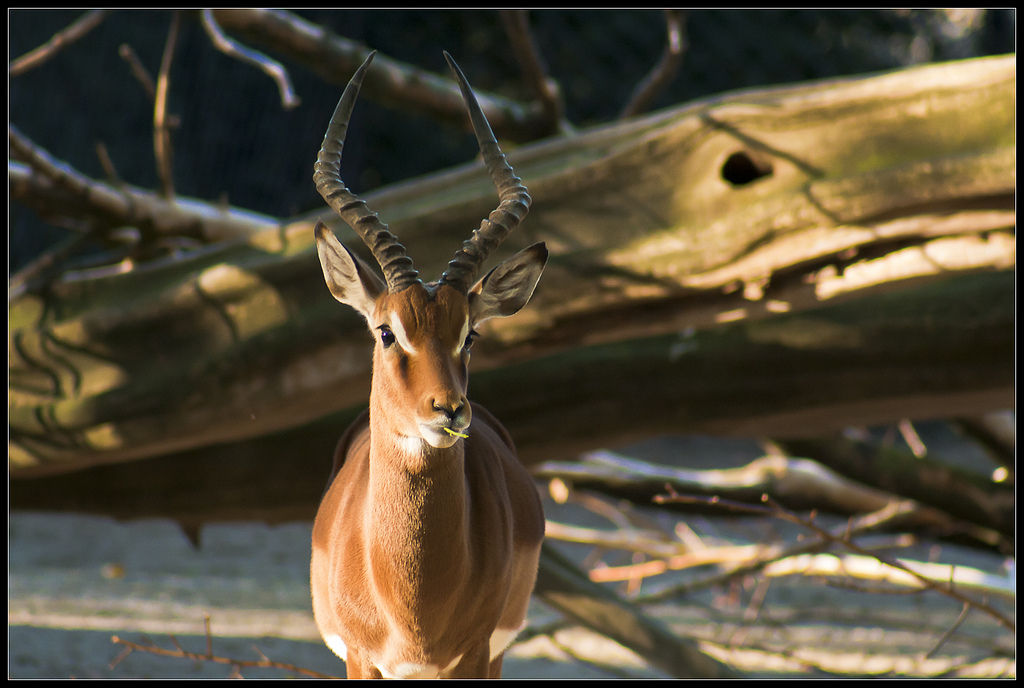

In [8]:
img

In [9]:
np.array(img).shape

(688, 1024, 3)

In [10]:
len(data)

37322

In [11]:

class AnimalDataset(Dataset):
    
    def __init__(self, data, transforms=None) -> None:
        self.data = data
        self.transforms = transforms
    
    def __getitem__(self, index):
        with Image.open(data[index]['path']) as img:
            img = img.convert('RGB')
        label = data[index]['idx'] 
        if self.transforms is not None:
            img = self.transforms(img)
        return {'img': img, 'label': label, 'idx': index}
    
    def __len__(self):
        return len(self.data)
    



In [ ]:
batch_size = 1
transforms = Compose([ToTensor(),
                      Resize((256, 256)), 
                      Normalize([0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])] 
                     )
dataset = AnimalDataset(data, transforms=transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
img = (next(iter(dataloader))['img'][0].numpy() * 255).astype(np.uint8)

In [ ]:
Image.fromarray(img.clip(max=255).swapaxes(0, 1).swapaxes(1, 2))

In [ ]:
img.shape

In [ ]:
model = resnet152()

In [ ]:
model

In [ ]:
model.fc = nn.Linear(model.fc.in_features, len(labels), bias=True)

## Train FP32

In [ ]:
batch_size = 64
transforms = Compose([ToTensor(),
                      Resize((256, 256)), 
                      Normalize([0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])] 
                     )
dataset = AnimalDataset(data, transforms=transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = resnet152(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(labels), bias=True)
with torch.no_grad():
    nn.init.xavier_uniform_(model.fc.weight)
    nn.init.constant_(model.fc.bias, 0.0)
num_epochs = 1
device = torch.device('cuda')
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for i in range(num_epochs):
    for j, batch_data in enumerate(dataloader):
        img, label = batch_data['img'], batch_data['label']
        img = img.to(device)
        label = label.to(device)
        
        out = model(img)
        loss = nn.functional.cross_entropy(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch: {i}, Batch: {j}/{len(dataloader)}, Loss: {loss.item()}")
        if j == 100:
            break

In [ ]:
torch.cuda.empty_cache()

In [ ]:
del model

In [ ]:
del optimizer

In [ ]:
batch_size = 128
transforms = Compose([ToTensor(),
                      Resize((256, 256)), 
                      Normalize([0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])] 
                     )
dataset = AnimalDataset(data, transforms=transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = resnet152(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(labels), bias=True)
with torch.no_grad():
    nn.init.xavier_uniform_(model.fc.weight)
    nn.init.constant_(model.fc.bias, 0.0)
num_epochs = 1
device = torch.device('cuda')
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()
for i in range(num_epochs):
    for j, batch_data in enumerate(dataloader):
        img, label = batch_data['img'], batch_data['label']
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        with autocast(dtype=torch.float16, device_type='cuda'):
            out = model(img)
            loss = nn.functional.cross_entropy(out, label)
        
        scaler.scale(loss).backward() 
        
        scaler.step(optimizer)
        
        scaler.update()
        
        print(f"Epoch: {i}, Batch: {j}/{len(dataloader)}, Loss: {loss.item()}")
        if j == 100:
            break

In [ ]:
del optimizer
del model
torch.cuda.empty_cache()

In [12]:
class FP16Optimizer:
    """
    Mixed precision optimizer with dynamic loss scaling and backoff.
    https://docs.nvidia.com/deeplearning/sdk/mixed-precision-training/index.html#scalefactor
    """
    @staticmethod
    def set_grads(params, params_with_grad):
        """
        Copies gradients from param_with_grad to params

        :param params: dst parameters
        :param params_with_grad: src parameters
        """
        for param, param_w_grad in zip(params, params_with_grad):
            if param.grad is None:
                param.grad = torch.nn.Parameter(torch.empty_like(param))
            param.grad.data.copy_(param_w_grad.grad.data)

    @staticmethod
    def set_weights(params, new_params):
        """
        Copies parameters from new_params to params

        :param params: dst parameters
        :param new_params: src parameters
        """
        for param, new_param in zip(params, new_params):
            param.data.copy_(new_param.data)

    def __init__(self, model, grad_clip=float('inf'), loss_scale=8192,
                 dls_downscale=2, dls_upscale=2, dls_upscale_interval=128):
        """
        Constructor for the Fp16Optimizer.

        :param model: model
        :param grad_clip: coefficient for gradient clipping, max L2 norm of the
            gradients
        :param loss_scale: initial loss scale
        :param dls_downscale: loss downscale factor, loss scale is divided by
            this factor when NaN/INF occurs in the gradients
        :param dls_upscale: loss upscale factor, loss scale is multiplied by
            this factor if previous dls_upscale_interval batches finished
            successfully
        :param dls_upscale_interval: interval for loss scale upscaling
        """
        print('Initializing fp16 optimizer')
        self.initialize_model(model)

        self.since_last_invalid = 0
        self.loss_scale = loss_scale
        self.dls_downscale = dls_downscale
        self.dls_upscale = dls_upscale
        self.dls_upscale_interval = dls_upscale_interval
        self.grad_clip = grad_clip

    def initialize_model(self, model):
        """
        Initializes internal state and build fp32 master copy of weights.

        :param model: fp16 model
        """
        print('Converting model to half precision')
        model.half()
        print('Initializing fp32 clone weights')
        self.model = model
        self.model.zero_grad()
        self.fp32_params = [param.to(torch.float32).detach()
                            for param in model.parameters()]

        for param in self.fp32_params:
            param.requires_grad = True

    def step(self, loss, optimizer, update=True):
        """
        Performs one step of the optimizer.
        Applies loss scaling, computes gradients in fp16, converts gradients to
        fp32, inverts scaling and applies optional gradient norm clipping.
        If gradients are finite, it applies update to fp32 master weights and
        copies updated parameters to fp16 model for the next iteration. If
        gradients are not finite, it skips the batch and adjusts scaling factor
        for the next iteration.

        :param loss: value of loss function
        :param optimizer: optimizer
        :param update: if True executes weight update
        """
        loss *= self.loss_scale
        loss.backward()

        if update:
            self.set_grads(self.fp32_params, self.model.parameters())
            if self.loss_scale != 1.0:
                for param in self.fp32_params:
                    param.grad.data /= self.loss_scale

            norm = nn.utils.clip_grad_norm_(self.fp32_params, self.grad_clip)

            if math.isfinite(norm):
                optimizer.step()
                self.set_weights(self.model.parameters(),
                                 self.fp32_params)
                self.since_last_invalid += 1
            else:
                self.loss_scale /= self.dls_downscale
                self.since_last_invalid = 0
                print(f'Gradient norm: {norm}')
                print(f'Skipped batch, new scale: {self.loss_scale}')

            if self.since_last_invalid >= self.dls_upscale_interval:
                self.loss_scale *= self.dls_upscale
                self.loss_scale = min(self.loss_scale, 8192.0)
                print(f'Upscaling, new scale: {self.loss_scale}')
                self.since_last_invalid = 0

            self.model.zero_grad()


In [13]:

batch_size = 128
transforms = Compose([ToTensor(),
                      Resize((256, 256)), 
                      Normalize([0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])] 
                     )
dataset = AnimalDataset(data, transforms=transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=10)
model = resnet152(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(labels), bias=True)
with torch.no_grad():
    nn.init.xavier_uniform_(model.fc.weight)
    nn.init.constant_(model.fc.bias, 0.0)
num_epochs = 25
device = torch.device('cuda')
model.cuda()
fp_16opt = FP16Optimizer(model)
optimizer = torch.optim.Adam(fp_16opt.fp32_params, lr=3e-6)

    
for i in range(num_epochs):
    for j, batch_data in enumerate(dataloader):
        img, label = batch_data['img'], batch_data['label']
        img = img.to(device).half()
        label = label.to(device)
        out = model(img)
        loss = nn.functional.cross_entropy(out, label)
        
        fp_16opt.step(loss / fp_16opt.loss_scale, optimizer)
        print(f"Epoch: {i}, Batch: {j}/{len(dataloader)}, Loss: {loss.item()}")

/home/mtb/env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initializing fp16 optimizer
Converting model to half precision
Initializing fp32 clone weights


/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 0, Batch: 0/292, Loss: 4.11328125
Epoch: 0, Batch: 1/292, Loss: 4.20703125
Epoch: 0, Batch: 2/292, Loss: 4.109375
Epoch: 0, Batch: 3/292, Loss: 4.109375
Epoch: 0, Batch: 4/292, Loss: 4.11328125
Epoch: 0, Batch: 5/292, Loss: 4.10546875
Epoch: 0, Batch: 6/292, Loss: 4.19921875
Epoch: 0, Batch: 7/292, Loss: 4.2109375
Epoch: 0, Batch: 8/292, Loss: 4.06640625
Epoch: 0, Batch: 9/292, Loss: 4.19921875
Epoch: 0, Batch: 10/292, Loss: 4.1171875
Epoch: 0, Batch: 11/292, Loss: 4.16015625
Epoch: 0, Batch: 12/292, Loss: 3.9765625
Epoch: 0, Batch: 13/292, Loss: 4.13671875
Epoch: 0, Batch: 14/292, Loss: 3.9765625
Epoch: 0, Batch: 15/292, Loss: 3.96875
Epoch: 0, Batch: 16/292, Loss: 4.015625
Epoch: 0, Batch: 17/292, Loss: 3.912109375
Epoch: 0, Batch: 18/292, Loss: 4.00390625
Epoch: 0, Batch: 19/292, Loss: 3.8984375
Epoch: 0, Batch: 20/292, Loss: 3.98828125
Epoch: 0, Batch: 21/292, Loss: 3.966796875
Epoch: 0, Batch: 22/292, Loss: 3.962890625
Epoch: 0, Batch: 23/292, Loss: 4.06640625
Epoch: 0, Bat

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 1, Batch: 0/292, Loss: 1.6298828125
Epoch: 1, Batch: 1/292, Loss: 1.419921875
Epoch: 1, Batch: 2/292, Loss: 1.443359375
Epoch: 1, Batch: 3/292, Loss: 1.5
Epoch: 1, Batch: 4/292, Loss: 1.4091796875
Epoch: 1, Batch: 5/292, Loss: 1.494140625
Epoch: 1, Batch: 6/292, Loss: 1.4580078125
Epoch: 1, Batch: 7/292, Loss: 1.45703125
Epoch: 1, Batch: 8/292, Loss: 1.56640625
Epoch: 1, Batch: 9/292, Loss: 1.4921875
Epoch: 1, Batch: 10/292, Loss: 1.3330078125
Epoch: 1, Batch: 11/292, Loss: 1.369140625
Epoch: 1, Batch: 12/292, Loss: 1.3955078125
Epoch: 1, Batch: 13/292, Loss: 1.4287109375
Epoch: 1, Batch: 14/292, Loss: 1.283203125
Epoch: 1, Batch: 15/292, Loss: 1.4375
Epoch: 1, Batch: 16/292, Loss: 1.4140625
Epoch: 1, Batch: 17/292, Loss: 1.4306640625
Epoch: 1, Batch: 18/292, Loss: 1.6572265625
Epoch: 1, Batch: 19/292, Loss: 1.453125
Epoch: 1, Batch: 20/292, Loss: 1.5517578125
Epoch: 1, Batch: 21/292, Loss: 1.3310546875
Epoch: 1, Batch: 22/292, Loss: 1.4521484375
Epoch: 1, Batch: 23/292, Loss: 1

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 2, Batch: 0/292, Loss: 0.72705078125
Epoch: 2, Batch: 1/292, Loss: 0.7841796875
Epoch: 2, Batch: 2/292, Loss: 0.7158203125
Epoch: 2, Batch: 3/292, Loss: 0.6669921875
Epoch: 2, Batch: 4/292, Loss: 0.576171875
Epoch: 2, Batch: 5/292, Loss: 0.67919921875
Epoch: 2, Batch: 6/292, Loss: 0.615234375
Epoch: 2, Batch: 7/292, Loss: 0.67626953125
Epoch: 2, Batch: 8/292, Loss: 0.82177734375
Epoch: 2, Batch: 9/292, Loss: 0.5927734375
Epoch: 2, Batch: 10/292, Loss: 0.6962890625
Epoch: 2, Batch: 11/292, Loss: 0.6689453125
Epoch: 2, Batch: 12/292, Loss: 0.80224609375
Epoch: 2, Batch: 13/292, Loss: 0.64501953125
Epoch: 2, Batch: 14/292, Loss: 0.75048828125
Epoch: 2, Batch: 15/292, Loss: 0.7705078125
Epoch: 2, Batch: 16/292, Loss: 0.59619140625
Epoch: 2, Batch: 17/292, Loss: 0.6357421875
Epoch: 2, Batch: 18/292, Loss: 0.55908203125
Epoch: 2, Batch: 19/292, Loss: 0.68701171875
Epoch: 2, Batch: 20/292, Loss: 0.61865234375
Epoch: 2, Batch: 21/292, Loss: 0.75732421875
Epoch: 2, Batch: 22/292, Loss: 0

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 3, Batch: 0/292, Loss: 0.486083984375
Epoch: 3, Batch: 1/292, Loss: 0.56103515625
Epoch: 3, Batch: 2/292, Loss: 0.50341796875
Epoch: 3, Batch: 3/292, Loss: 0.472412109375
Epoch: 3, Batch: 4/292, Loss: 0.380859375
Epoch: 3, Batch: 5/292, Loss: 0.397216796875
Epoch: 3, Batch: 6/292, Loss: 0.46875
Epoch: 3, Batch: 7/292, Loss: 0.39501953125
Epoch: 3, Batch: 8/292, Loss: 0.37548828125
Epoch: 3, Batch: 9/292, Loss: 0.44970703125
Epoch: 3, Batch: 10/292, Loss: 0.469482421875
Epoch: 3, Batch: 11/292, Loss: 0.438232421875
Epoch: 3, Batch: 12/292, Loss: 0.440185546875
Epoch: 3, Batch: 13/292, Loss: 0.362060546875
Epoch: 3, Batch: 14/292, Loss: 0.3369140625
Epoch: 3, Batch: 15/292, Loss: 0.400634765625
Epoch: 3, Batch: 16/292, Loss: 0.39501953125
Epoch: 3, Batch: 17/292, Loss: 0.34423828125
Epoch: 3, Batch: 18/292, Loss: 0.337646484375
Upscaling, new scale: 8192.0
Epoch: 3, Batch: 19/292, Loss: 0.4111328125
Epoch: 3, Batch: 20/292, Loss: 0.33447265625
Epoch: 3, Batch: 21/292, Loss: 0.3918

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 4, Batch: 0/292, Loss: 0.30322265625
Epoch: 4, Batch: 1/292, Loss: 0.345458984375
Epoch: 4, Batch: 2/292, Loss: 0.278564453125
Epoch: 4, Batch: 3/292, Loss: 0.320068359375
Epoch: 4, Batch: 4/292, Loss: 0.32177734375
Epoch: 4, Batch: 5/292, Loss: 0.24462890625
Epoch: 4, Batch: 6/292, Loss: 0.2373046875
Epoch: 4, Batch: 7/292, Loss: 0.256103515625
Epoch: 4, Batch: 8/292, Loss: 0.24951171875
Epoch: 4, Batch: 9/292, Loss: 0.3310546875
Epoch: 4, Batch: 10/292, Loss: 0.297119140625
Epoch: 4, Batch: 11/292, Loss: 0.294921875
Epoch: 4, Batch: 12/292, Loss: 0.35693359375
Epoch: 4, Batch: 13/292, Loss: 0.3642578125
Epoch: 4, Batch: 14/292, Loss: 0.25
Epoch: 4, Batch: 15/292, Loss: 0.267822265625
Epoch: 4, Batch: 16/292, Loss: 0.294189453125
Epoch: 4, Batch: 17/292, Loss: 0.271484375
Epoch: 4, Batch: 18/292, Loss: 0.34912109375
Epoch: 4, Batch: 19/292, Loss: 0.30322265625
Epoch: 4, Batch: 20/292, Loss: 0.316650390625
Epoch: 4, Batch: 21/292, Loss: 0.283203125
Epoch: 4, Batch: 22/292, Loss:

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 5, Batch: 0/292, Loss: 0.24267578125
Epoch: 5, Batch: 1/292, Loss: 0.152587890625
Epoch: 5, Batch: 2/292, Loss: 0.151123046875
Epoch: 5, Batch: 3/292, Loss: 0.2352294921875
Epoch: 5, Batch: 4/292, Loss: 0.235107421875
Epoch: 5, Batch: 5/292, Loss: 0.21875
Epoch: 5, Batch: 6/292, Loss: 0.161376953125
Epoch: 5, Batch: 7/292, Loss: 0.24560546875
Epoch: 5, Batch: 8/292, Loss: 0.2269287109375
Epoch: 5, Batch: 9/292, Loss: 0.27587890625
Epoch: 5, Batch: 10/292, Loss: 0.2471923828125
Epoch: 5, Batch: 11/292, Loss: 0.203369140625
Epoch: 5, Batch: 12/292, Loss: 0.23583984375
Epoch: 5, Batch: 13/292, Loss: 0.1593017578125
Epoch: 5, Batch: 14/292, Loss: 0.23974609375
Epoch: 5, Batch: 15/292, Loss: 0.171142578125
Epoch: 5, Batch: 16/292, Loss: 0.30859375
Epoch: 5, Batch: 17/292, Loss: 0.15087890625
Epoch: 5, Batch: 18/292, Loss: 0.2220458984375
Epoch: 5, Batch: 19/292, Loss: 0.25146484375
Epoch: 5, Batch: 20/292, Loss: 0.1595458984375
Epoch: 5, Batch: 21/292, Loss: 0.167724609375
Epoch: 5, 

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 6, Batch: 0/292, Loss: 0.134521484375
Epoch: 6, Batch: 1/292, Loss: 0.2119140625
Epoch: 6, Batch: 2/292, Loss: 0.1241455078125
Epoch: 6, Batch: 3/292, Loss: 0.1531982421875
Epoch: 6, Batch: 4/292, Loss: 0.1435546875
Epoch: 6, Batch: 5/292, Loss: 0.147705078125
Epoch: 6, Batch: 6/292, Loss: 0.190673828125
Epoch: 6, Batch: 7/292, Loss: 0.273193359375
Epoch: 6, Batch: 8/292, Loss: 0.1282958984375
Epoch: 6, Batch: 9/292, Loss: 0.1507568359375
Epoch: 6, Batch: 10/292, Loss: 0.1409912109375
Epoch: 6, Batch: 11/292, Loss: 0.152099609375
Epoch: 6, Batch: 12/292, Loss: 0.1041259765625
Epoch: 6, Batch: 13/292, Loss: 0.19140625
Epoch: 6, Batch: 14/292, Loss: 0.1640625
Epoch: 6, Batch: 15/292, Loss: 0.1597900390625
Epoch: 6, Batch: 16/292, Loss: 0.136962890625
Epoch: 6, Batch: 17/292, Loss: 0.2095947265625
Epoch: 6, Batch: 18/292, Loss: 0.1634521484375
Epoch: 6, Batch: 19/292, Loss: 0.1552734375
Epoch: 6, Batch: 20/292, Loss: 0.1695556640625
Epoch: 6, Batch: 21/292, Loss: 0.11566162109375
E

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 7, Batch: 0/292, Loss: 0.143798828125
Epoch: 7, Batch: 1/292, Loss: 0.09112548828125
Epoch: 7, Batch: 2/292, Loss: 0.0975341796875
Upscaling, new scale: 8192.0
Epoch: 7, Batch: 3/292, Loss: 0.1163330078125
Epoch: 7, Batch: 4/292, Loss: 0.1685791015625
Epoch: 7, Batch: 5/292, Loss: 0.1163330078125
Epoch: 7, Batch: 6/292, Loss: 0.11383056640625
Epoch: 7, Batch: 7/292, Loss: 0.1502685546875
Epoch: 7, Batch: 8/292, Loss: 0.08001708984375
Epoch: 7, Batch: 9/292, Loss: 0.10797119140625
Epoch: 7, Batch: 10/292, Loss: 0.1463623046875
Epoch: 7, Batch: 11/292, Loss: 0.074462890625
Epoch: 7, Batch: 12/292, Loss: 0.09429931640625
Epoch: 7, Batch: 13/292, Loss: 0.112060546875
Epoch: 7, Batch: 14/292, Loss: 0.1370849609375
Epoch: 7, Batch: 15/292, Loss: 0.0736083984375
Epoch: 7, Batch: 16/292, Loss: 0.12841796875
Epoch: 7, Batch: 17/292, Loss: 0.12078857421875
Epoch: 7, Batch: 18/292, Loss: 0.108642578125
Epoch: 7, Batch: 19/292, Loss: 0.1239013671875
Epoch: 7, Batch: 20/292, Loss: 0.15222167

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 8, Batch: 0/292, Loss: 0.06634521484375
Epoch: 8, Batch: 1/292, Loss: 0.09332275390625
Epoch: 8, Batch: 2/292, Loss: 0.0728759765625
Epoch: 8, Batch: 3/292, Loss: 0.121826171875
Epoch: 8, Batch: 4/292, Loss: 0.1090087890625
Epoch: 8, Batch: 5/292, Loss: 0.1015625
Epoch: 8, Batch: 6/292, Loss: 0.10760498046875
Epoch: 8, Batch: 7/292, Loss: 0.05169677734375
Epoch: 8, Batch: 8/292, Loss: 0.10418701171875
Epoch: 8, Batch: 9/292, Loss: 0.114013671875
Epoch: 8, Batch: 10/292, Loss: 0.08685302734375
Epoch: 8, Batch: 11/292, Loss: 0.0872802734375
Epoch: 8, Batch: 12/292, Loss: 0.07281494140625
Epoch: 8, Batch: 13/292, Loss: 0.0643310546875
Epoch: 8, Batch: 14/292, Loss: 0.08819580078125
Epoch: 8, Batch: 15/292, Loss: 0.060882568359375
Epoch: 8, Batch: 16/292, Loss: 0.061767578125
Epoch: 8, Batch: 17/292, Loss: 0.09600830078125
Epoch: 8, Batch: 18/292, Loss: 0.075927734375
Epoch: 8, Batch: 19/292, Loss: 0.0887451171875
Epoch: 8, Batch: 20/292, Loss: 0.137939453125
Epoch: 8, Batch: 21/292

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 9, Batch: 0/292, Loss: 0.07464599609375
Epoch: 9, Batch: 1/292, Loss: 0.08746337890625
Epoch: 9, Batch: 2/292, Loss: 0.04620361328125
Epoch: 9, Batch: 3/292, Loss: 0.0902099609375
Epoch: 9, Batch: 4/292, Loss: 0.07672119140625
Epoch: 9, Batch: 5/292, Loss: 0.11065673828125
Epoch: 9, Batch: 6/292, Loss: 0.07421875
Epoch: 9, Batch: 7/292, Loss: 0.054656982421875
Epoch: 9, Batch: 8/292, Loss: 0.070556640625
Epoch: 9, Batch: 9/292, Loss: 0.08026123046875
Epoch: 9, Batch: 10/292, Loss: 0.09625244140625
Epoch: 9, Batch: 11/292, Loss: 0.057861328125
Epoch: 9, Batch: 12/292, Loss: 0.08544921875
Epoch: 9, Batch: 13/292, Loss: 0.0535888671875
Epoch: 9, Batch: 14/292, Loss: 0.077392578125
Epoch: 9, Batch: 15/292, Loss: 0.07720947265625
Epoch: 9, Batch: 16/292, Loss: 0.120849609375
Epoch: 9, Batch: 17/292, Loss: 0.0621337890625
Epoch: 9, Batch: 18/292, Loss: 0.07110595703125
Epoch: 9, Batch: 19/292, Loss: 0.05987548828125
Epoch: 9, Batch: 20/292, Loss: 0.06982421875
Epoch: 9, Batch: 21/292,

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 10, Batch: 0/292, Loss: 0.076904296875
Epoch: 10, Batch: 1/292, Loss: 0.052337646484375
Epoch: 10, Batch: 2/292, Loss: 0.044586181640625
Epoch: 10, Batch: 3/292, Loss: 0.058380126953125
Epoch: 10, Batch: 4/292, Loss: 0.07330322265625
Epoch: 10, Batch: 5/292, Loss: 0.07000732421875
Epoch: 10, Batch: 6/292, Loss: 0.06829833984375
Epoch: 10, Batch: 7/292, Loss: 0.04351806640625
Epoch: 10, Batch: 8/292, Loss: 0.05120849609375
Epoch: 10, Batch: 9/292, Loss: 0.053680419921875
Epoch: 10, Batch: 10/292, Loss: 0.035491943359375
Epoch: 10, Batch: 11/292, Loss: 0.06256103515625
Epoch: 10, Batch: 12/292, Loss: 0.0587158203125
Epoch: 10, Batch: 13/292, Loss: 0.051116943359375
Epoch: 10, Batch: 14/292, Loss: 0.04827880859375
Epoch: 10, Batch: 15/292, Loss: 0.0784912109375
Epoch: 10, Batch: 16/292, Loss: 0.06640625
Epoch: 10, Batch: 17/292, Loss: 0.0970458984375
Epoch: 10, Batch: 18/292, Loss: 0.06317138671875
Epoch: 10, Batch: 19/292, Loss: 0.04071044921875
Epoch: 10, Batch: 20/292, Loss: 0.0

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 11, Batch: 0/292, Loss: 0.052642822265625
Epoch: 11, Batch: 1/292, Loss: 0.030517578125
Epoch: 11, Batch: 2/292, Loss: 0.052459716796875
Epoch: 11, Batch: 3/292, Loss: 0.0321044921875
Epoch: 11, Batch: 4/292, Loss: 0.048065185546875
Epoch: 11, Batch: 5/292, Loss: 0.047271728515625
Epoch: 11, Batch: 6/292, Loss: 0.050750732421875
Epoch: 11, Batch: 7/292, Loss: 0.0263824462890625
Epoch: 11, Batch: 8/292, Loss: 0.03717041015625
Epoch: 11, Batch: 9/292, Loss: 0.05377197265625
Epoch: 11, Batch: 10/292, Loss: 0.068115234375
Epoch: 11, Batch: 11/292, Loss: 0.029083251953125
Epoch: 11, Batch: 12/292, Loss: 0.0716552734375
Epoch: 11, Batch: 13/292, Loss: 0.061553955078125
Epoch: 11, Batch: 14/292, Loss: 0.04864501953125
Epoch: 11, Batch: 15/292, Loss: 0.03875732421875
Epoch: 11, Batch: 16/292, Loss: 0.0406494140625
Epoch: 11, Batch: 17/292, Loss: 0.044708251953125
Epoch: 11, Batch: 18/292, Loss: 0.059234619140625
Epoch: 11, Batch: 19/292, Loss: 0.050567626953125
Epoch: 11, Batch: 20/292,

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 12, Batch: 0/292, Loss: 0.04949951171875
Epoch: 12, Batch: 1/292, Loss: 0.05560302734375
Epoch: 12, Batch: 2/292, Loss: 0.0188751220703125
Epoch: 12, Batch: 3/292, Loss: 0.029144287109375
Epoch: 12, Batch: 4/292, Loss: 0.03125
Epoch: 12, Batch: 5/292, Loss: 0.048065185546875
Epoch: 12, Batch: 6/292, Loss: 0.07659912109375
Epoch: 12, Batch: 7/292, Loss: 0.0521240234375
Epoch: 12, Batch: 8/292, Loss: 0.050933837890625
Epoch: 12, Batch: 9/292, Loss: 0.028106689453125
Epoch: 12, Batch: 10/292, Loss: 0.03594970703125
Epoch: 12, Batch: 11/292, Loss: 0.0211029052734375
Epoch: 12, Batch: 12/292, Loss: 0.03155517578125
Epoch: 12, Batch: 13/292, Loss: 0.0301055908203125
Epoch: 12, Batch: 14/292, Loss: 0.040130615234375
Epoch: 12, Batch: 15/292, Loss: 0.02972412109375
Epoch: 12, Batch: 16/292, Loss: 0.0227508544921875
Epoch: 12, Batch: 17/292, Loss: 0.047943115234375
Epoch: 12, Batch: 18/292, Loss: 0.032684326171875
Epoch: 12, Batch: 19/292, Loss: 0.0313720703125
Epoch: 12, Batch: 20/292, 

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 13, Batch: 0/292, Loss: 0.033172607421875
Epoch: 13, Batch: 1/292, Loss: 0.023468017578125
Epoch: 13, Batch: 2/292, Loss: 0.03125
Epoch: 13, Batch: 3/292, Loss: 0.042572021484375
Epoch: 13, Batch: 4/292, Loss: 0.0380859375
Epoch: 13, Batch: 5/292, Loss: 0.029571533203125
Epoch: 13, Batch: 6/292, Loss: 0.03350830078125
Epoch: 13, Batch: 7/292, Loss: 0.033966064453125
Epoch: 13, Batch: 8/292, Loss: 0.02960205078125
Epoch: 13, Batch: 9/292, Loss: 0.0215606689453125
Epoch: 13, Batch: 10/292, Loss: 0.0330810546875
Epoch: 13, Batch: 11/292, Loss: 0.033050537109375
Epoch: 13, Batch: 12/292, Loss: 0.048187255859375
Epoch: 13, Batch: 13/292, Loss: 0.054107666015625
Epoch: 13, Batch: 14/292, Loss: 0.0224761962890625
Epoch: 13, Batch: 15/292, Loss: 0.036224365234375
Epoch: 13, Batch: 16/292, Loss: 0.05877685546875
Epoch: 13, Batch: 17/292, Loss: 0.02783203125
Epoch: 13, Batch: 18/292, Loss: 0.020721435546875
Epoch: 13, Batch: 19/292, Loss: 0.0244293212890625
Epoch: 13, Batch: 20/292, Loss:

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 14, Batch: 0/292, Loss: 0.0210723876953125
Epoch: 14, Batch: 1/292, Loss: 0.02777099609375
Epoch: 14, Batch: 2/292, Loss: 0.0160369873046875
Epoch: 14, Batch: 3/292, Loss: 0.0190277099609375
Epoch: 14, Batch: 4/292, Loss: 0.0265350341796875
Epoch: 14, Batch: 5/292, Loss: 0.021942138671875
Epoch: 14, Batch: 6/292, Loss: 0.019012451171875
Upscaling, new scale: 8192.0
Epoch: 14, Batch: 7/292, Loss: 0.0445556640625
Epoch: 14, Batch: 8/292, Loss: 0.0310211181640625
Epoch: 14, Batch: 9/292, Loss: 0.019256591796875
Epoch: 14, Batch: 10/292, Loss: 0.0185546875
Epoch: 14, Batch: 11/292, Loss: 0.0226287841796875
Epoch: 14, Batch: 12/292, Loss: 0.014923095703125
Epoch: 14, Batch: 13/292, Loss: 0.0394287109375
Epoch: 14, Batch: 14/292, Loss: 0.021484375
Epoch: 14, Batch: 15/292, Loss: 0.016448974609375
Epoch: 14, Batch: 16/292, Loss: 0.0242919921875
Epoch: 14, Batch: 17/292, Loss: 0.02252197265625
Epoch: 14, Batch: 18/292, Loss: 0.0201263427734375
Epoch: 14, Batch: 19/292, Loss: 0.014801025

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 15, Batch: 0/292, Loss: 0.02032470703125
Epoch: 15, Batch: 1/292, Loss: 0.016815185546875
Epoch: 15, Batch: 2/292, Loss: 0.017303466796875
Epoch: 15, Batch: 3/292, Loss: 0.0150604248046875
Epoch: 15, Batch: 4/292, Loss: 0.03680419921875
Epoch: 15, Batch: 5/292, Loss: 0.0185394287109375
Epoch: 15, Batch: 6/292, Loss: 0.01371002197265625
Epoch: 15, Batch: 7/292, Loss: 0.01409149169921875
Epoch: 15, Batch: 8/292, Loss: 0.022979736328125
Epoch: 15, Batch: 9/292, Loss: 0.01129913330078125
Epoch: 15, Batch: 10/292, Loss: 0.0162811279296875
Epoch: 15, Batch: 11/292, Loss: 0.0186309814453125
Epoch: 15, Batch: 12/292, Loss: 0.01375579833984375
Epoch: 15, Batch: 13/292, Loss: 0.0172119140625
Epoch: 15, Batch: 14/292, Loss: 0.01209259033203125
Epoch: 15, Batch: 15/292, Loss: 0.01959228515625
Epoch: 15, Batch: 16/292, Loss: 0.0182952880859375
Epoch: 15, Batch: 17/292, Loss: 0.01470947265625
Epoch: 15, Batch: 18/292, Loss: 0.02313232421875
Epoch: 15, Batch: 19/292, Loss: 0.0310821533203125
E

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 16, Batch: 0/292, Loss: 0.01336669921875
Epoch: 16, Batch: 1/292, Loss: 0.011016845703125
Epoch: 16, Batch: 2/292, Loss: 0.01433563232421875
Epoch: 16, Batch: 3/292, Loss: 0.0188140869140625
Epoch: 16, Batch: 4/292, Loss: 0.01169586181640625
Epoch: 16, Batch: 5/292, Loss: 0.00885009765625
Epoch: 16, Batch: 6/292, Loss: 0.014617919921875
Epoch: 16, Batch: 7/292, Loss: 0.02294921875
Epoch: 16, Batch: 8/292, Loss: 0.03497314453125
Epoch: 16, Batch: 9/292, Loss: 0.012969970703125
Epoch: 16, Batch: 10/292, Loss: 0.0165557861328125
Epoch: 16, Batch: 11/292, Loss: 0.01090240478515625
Epoch: 16, Batch: 12/292, Loss: 0.02197265625
Epoch: 16, Batch: 13/292, Loss: 0.0204315185546875
Epoch: 16, Batch: 14/292, Loss: 0.026092529296875
Epoch: 16, Batch: 15/292, Loss: 0.016754150390625
Epoch: 16, Batch: 16/292, Loss: 0.01265716552734375
Epoch: 16, Batch: 17/292, Loss: 0.0130615234375
Epoch: 16, Batch: 18/292, Loss: 0.01183319091796875
Epoch: 16, Batch: 19/292, Loss: 0.00948333740234375
Epoch: 1

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 17, Batch: 0/292, Loss: 0.02056884765625
Epoch: 17, Batch: 1/292, Loss: 0.0125885009765625
Epoch: 17, Batch: 2/292, Loss: 0.011993408203125
Epoch: 17, Batch: 3/292, Loss: 0.0108642578125
Epoch: 17, Batch: 4/292, Loss: 0.012664794921875
Epoch: 17, Batch: 5/292, Loss: 0.0117034912109375
Epoch: 17, Batch: 6/292, Loss: 0.0168914794921875
Epoch: 17, Batch: 7/292, Loss: 0.008209228515625
Epoch: 17, Batch: 8/292, Loss: 0.021209716796875
Epoch: 17, Batch: 9/292, Loss: 0.01064300537109375
Epoch: 17, Batch: 10/292, Loss: 0.01165771484375
Epoch: 17, Batch: 11/292, Loss: 0.036376953125
Epoch: 17, Batch: 12/292, Loss: 0.0209197998046875
Epoch: 17, Batch: 13/292, Loss: 0.0137939453125
Epoch: 17, Batch: 14/292, Loss: 0.01184844970703125
Epoch: 17, Batch: 15/292, Loss: 0.015350341796875
Epoch: 17, Batch: 16/292, Loss: 0.0265350341796875
Epoch: 17, Batch: 17/292, Loss: 0.007572174072265625
Epoch: 17, Batch: 18/292, Loss: 0.01329803466796875
Epoch: 17, Batch: 19/292, Loss: 0.014404296875
Epoch: 1

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 18, Batch: 0/292, Loss: 0.009033203125
Epoch: 18, Batch: 1/292, Loss: 0.0112457275390625
Epoch: 18, Batch: 2/292, Loss: 0.0118560791015625
Epoch: 18, Batch: 3/292, Loss: 0.0213775634765625
Epoch: 18, Batch: 4/292, Loss: 0.00843048095703125
Epoch: 18, Batch: 5/292, Loss: 0.01143646240234375
Epoch: 18, Batch: 6/292, Loss: 0.00720977783203125
Epoch: 18, Batch: 7/292, Loss: 0.00968170166015625
Epoch: 18, Batch: 8/292, Loss: 0.0168304443359375
Epoch: 18, Batch: 9/292, Loss: 0.01312255859375
Epoch: 18, Batch: 10/292, Loss: 0.00798797607421875
Epoch: 18, Batch: 11/292, Loss: 0.01131439208984375
Epoch: 18, Batch: 12/292, Loss: 0.0101470947265625
Epoch: 18, Batch: 13/292, Loss: 0.013092041015625
Epoch: 18, Batch: 14/292, Loss: 0.0075531005859375
Epoch: 18, Batch: 15/292, Loss: 0.00844573974609375
Epoch: 18, Batch: 16/292, Loss: 0.0110015869140625
Epoch: 18, Batch: 17/292, Loss: 0.00722503662109375
Epoch: 18, Batch: 18/292, Loss: 0.03070068359375
Epoch: 18, Batch: 19/292, Loss: 0.01049041

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 19, Batch: 0/292, Loss: 0.036529541015625
Epoch: 19, Batch: 1/292, Loss: 0.00811004638671875
Epoch: 19, Batch: 2/292, Loss: 0.0181427001953125
Epoch: 19, Batch: 3/292, Loss: 0.00710296630859375
Epoch: 19, Batch: 4/292, Loss: 0.00917816162109375
Epoch: 19, Batch: 5/292, Loss: 0.02301025390625
Epoch: 19, Batch: 6/292, Loss: 0.007450103759765625
Epoch: 19, Batch: 7/292, Loss: 0.0101165771484375
Epoch: 19, Batch: 8/292, Loss: 0.010833740234375
Epoch: 19, Batch: 9/292, Loss: 0.00972747802734375
Epoch: 19, Batch: 10/292, Loss: 0.0092620849609375
Epoch: 19, Batch: 11/292, Loss: 0.01053619384765625
Epoch: 19, Batch: 12/292, Loss: 0.01226806640625
Epoch: 19, Batch: 13/292, Loss: 0.005870819091796875
Epoch: 19, Batch: 14/292, Loss: 0.01629638671875
Epoch: 19, Batch: 15/292, Loss: 0.007061004638671875
Epoch: 19, Batch: 16/292, Loss: 0.009857177734375
Epoch: 19, Batch: 17/292, Loss: 0.0172119140625
Epoch: 19, Batch: 18/292, Loss: 0.0059967041015625
Epoch: 19, Batch: 19/292, Loss: 0.01350402

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 20, Batch: 0/292, Loss: 0.00531768798828125
Epoch: 20, Batch: 1/292, Loss: 0.021392822265625
Epoch: 20, Batch: 2/292, Loss: 0.029266357421875
Epoch: 20, Batch: 3/292, Loss: 0.008941650390625
Epoch: 20, Batch: 4/292, Loss: 0.004486083984375
Epoch: 20, Batch: 5/292, Loss: 0.00994873046875
Epoch: 20, Batch: 6/292, Loss: 0.007476806640625
Epoch: 20, Batch: 7/292, Loss: 0.00748443603515625
Epoch: 20, Batch: 8/292, Loss: 0.019195556640625
Epoch: 20, Batch: 9/292, Loss: 0.007244110107421875
Epoch: 20, Batch: 10/292, Loss: 0.006938934326171875
Epoch: 20, Batch: 11/292, Loss: 0.00786590576171875
Epoch: 20, Batch: 12/292, Loss: 0.0087127685546875
Epoch: 20, Batch: 13/292, Loss: 0.0054931640625
Epoch: 20, Batch: 14/292, Loss: 0.00823974609375
Epoch: 20, Batch: 15/292, Loss: 0.009185791015625
Epoch: 20, Batch: 16/292, Loss: 0.00962066650390625
Epoch: 20, Batch: 17/292, Loss: 0.00702667236328125
Epoch: 20, Batch: 18/292, Loss: 0.0080108642578125
Epoch: 20, Batch: 19/292, Loss: 0.010871887207

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 21, Batch: 0/292, Loss: 0.0065460205078125
Epoch: 21, Batch: 1/292, Loss: 0.017974853515625
Epoch: 21, Batch: 2/292, Loss: 0.005519866943359375
Epoch: 21, Batch: 3/292, Loss: 0.009765625
Epoch: 21, Batch: 4/292, Loss: 0.00894927978515625
Epoch: 21, Batch: 5/292, Loss: 0.00638580322265625
Epoch: 21, Batch: 6/292, Loss: 0.010101318359375
Epoch: 21, Batch: 7/292, Loss: 0.00792694091796875
Epoch: 21, Batch: 8/292, Loss: 0.01328277587890625
Epoch: 21, Batch: 9/292, Loss: 0.0072784423828125
Epoch: 21, Batch: 10/292, Loss: 0.006855010986328125
Upscaling, new scale: 8192.0
Epoch: 21, Batch: 11/292, Loss: 0.00971221923828125
Epoch: 21, Batch: 12/292, Loss: 0.0087890625
Epoch: 21, Batch: 13/292, Loss: 0.00548553466796875
Epoch: 21, Batch: 14/292, Loss: 0.009002685546875
Epoch: 21, Batch: 15/292, Loss: 0.00847625732421875
Epoch: 21, Batch: 16/292, Loss: 0.0064849853515625
Epoch: 21, Batch: 17/292, Loss: 0.006580352783203125
Epoch: 21, Batch: 18/292, Loss: 0.0152130126953125
Epoch: 21, Batc

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 22, Batch: 0/292, Loss: 0.01279449462890625
Epoch: 22, Batch: 1/292, Loss: 0.006481170654296875
Epoch: 22, Batch: 2/292, Loss: 0.01514434814453125
Epoch: 22, Batch: 3/292, Loss: 0.00555419921875
Epoch: 22, Batch: 4/292, Loss: 0.020416259765625
Epoch: 22, Batch: 5/292, Loss: 0.0053253173828125
Epoch: 22, Batch: 6/292, Loss: 0.00804901123046875
Epoch: 22, Batch: 7/292, Loss: 0.00453948974609375
Epoch: 22, Batch: 8/292, Loss: 0.005710601806640625
Epoch: 22, Batch: 9/292, Loss: 0.00461578369140625
Epoch: 22, Batch: 10/292, Loss: 0.004978179931640625
Epoch: 22, Batch: 11/292, Loss: 0.007587432861328125
Epoch: 22, Batch: 12/292, Loss: 0.0102996826171875
Epoch: 22, Batch: 13/292, Loss: 0.005268096923828125
Epoch: 22, Batch: 14/292, Loss: 0.00467681884765625
Epoch: 22, Batch: 15/292, Loss: 0.006641387939453125
Epoch: 22, Batch: 16/292, Loss: 0.005741119384765625
Epoch: 22, Batch: 17/292, Loss: 0.005706787109375
Epoch: 22, Batch: 18/292, Loss: 0.02899169921875
Epoch: 22, Batch: 19/292, L

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 23, Batch: 0/292, Loss: 0.004547119140625
Epoch: 23, Batch: 1/292, Loss: 0.004383087158203125
Epoch: 23, Batch: 2/292, Loss: 0.00531005859375
Epoch: 23, Batch: 3/292, Loss: 0.0135498046875
Epoch: 23, Batch: 4/292, Loss: 0.004314422607421875
Epoch: 23, Batch: 5/292, Loss: 0.00494384765625
Epoch: 23, Batch: 6/292, Loss: 0.01027679443359375
Epoch: 23, Batch: 7/292, Loss: 0.00696563720703125
Epoch: 23, Batch: 8/292, Loss: 0.012908935546875
Epoch: 23, Batch: 9/292, Loss: 0.006130218505859375
Epoch: 23, Batch: 10/292, Loss: 0.006122589111328125
Epoch: 23, Batch: 11/292, Loss: 0.01546478271484375
Epoch: 23, Batch: 12/292, Loss: 0.006244659423828125
Epoch: 23, Batch: 13/292, Loss: 0.00634002685546875
Epoch: 23, Batch: 14/292, Loss: 0.00843048095703125
Epoch: 23, Batch: 15/292, Loss: 0.0038890838623046875
Epoch: 23, Batch: 16/292, Loss: 0.007183074951171875
Epoch: 23, Batch: 17/292, Loss: 0.0050506591796875
Epoch: 23, Batch: 18/292, Loss: 0.0039520263671875
Epoch: 23, Batch: 19/292, Loss

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

Epoch: 24, Batch: 0/292, Loss: 0.005107879638671875
Epoch: 24, Batch: 1/292, Loss: 0.0037841796875
Epoch: 24, Batch: 2/292, Loss: 0.0037384033203125
Epoch: 24, Batch: 3/292, Loss: 0.004817962646484375
Epoch: 24, Batch: 4/292, Loss: 0.004375457763671875
Epoch: 24, Batch: 5/292, Loss: 0.006587982177734375
Epoch: 24, Batch: 6/292, Loss: 0.0063629150390625
Epoch: 24, Batch: 7/292, Loss: 0.007755279541015625
Epoch: 24, Batch: 8/292, Loss: 0.00461578369140625
Epoch: 24, Batch: 9/292, Loss: 0.032745361328125
Epoch: 24, Batch: 10/292, Loss: 0.004642486572265625
Epoch: 24, Batch: 11/292, Loss: 0.00537872314453125
Epoch: 24, Batch: 12/292, Loss: 0.0257568359375
Epoch: 24, Batch: 13/292, Loss: 0.004581451416015625
Epoch: 24, Batch: 14/292, Loss: 0.02435302734375
Epoch: 24, Batch: 15/292, Loss: 0.00525665283203125
Epoch: 24, Batch: 16/292, Loss: 0.01187896728515625
Epoch: 24, Batch: 17/292, Loss: 0.0037631988525390625
Epoch: 24, Batch: 18/292, Loss: 0.020050048828125
Epoch: 24, Batch: 19/292, Loss

In [25]:
for j, batch_data in enumerate(dataloader):
    img, label = batch_data['img'], batch_data['label']
    test_idx = 10
    
    
    print(label[test_idx: test_idx + 1], labels[label[test_idx: test_idx + 1].item()])
    break

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

tensor([25]) hamster


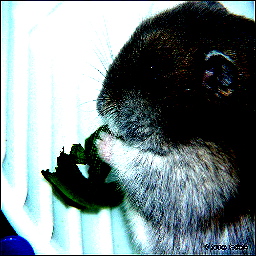

In [26]:
Image.fromarray((img[test_idx:test_idx+1][0].moveaxis((0, 1, 2), (2, 0, 1)).detach().cpu().numpy() * 255).clip(0, 255).astype(np.uint8))

In [27]:
max_label = torch.softmax(model(img[test_idx:test_idx+1].half().cuda()), dim=-1).argmax(dim=-1)
max_label, labels[max_label.item()]

(tensor([6], device='cuda:0'), 'horse')

In [28]:
model(img[test_idx:test_idx+1].half().cuda()).sort()

torch.return_types.sort(
values=tensor([[-1.1680e+00, -1.0420e+00, -1.0146e+00, -9.8096e-01, -9.7266e-01,
         -9.6436e-01, -8.8916e-01, -8.6572e-01, -8.3398e-01, -7.8809e-01,
         -7.8174e-01, -7.7002e-01, -7.6807e-01, -7.6611e-01, -7.5635e-01,
         -7.4023e-01, -6.7920e-01, -6.7090e-01, -6.5820e-01, -6.5625e-01,
         -6.3867e-01, -6.1670e-01, -5.7520e-01, -5.5811e-01, -5.4346e-01,
         -5.3857e-01, -5.3516e-01, -5.2881e-01, -4.9707e-01, -4.7900e-01,
         -4.6191e-01, -4.5483e-01, -4.5361e-01, -4.2188e-01, -3.7744e-01,
         -3.7061e-01, -3.6963e-01, -3.5669e-01, -3.4717e-01, -3.1787e-01,
         -3.0811e-01, -2.8955e-01, -2.3035e-01, -2.2473e-01, -1.8213e-01,
         -1.4014e-01, -7.8247e-02, -6.5063e-02, -6.5708e-04,  2.1228e-01]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SortBackward0>),
indices=tensor([[ 2,  8, 49,  0, 44, 33, 43, 47,  3, 27, 34, 16, 10, 21,  4, 18, 25, 31,
         24, 32, 29, 13, 26, 17, 12, 35, 46, 14, 30, 11, 40,  9, 1

In [ ]:
del optimizer
del model
del fp_16opt
torch.cuda.empty_cache()

In [34]:
model.cpu()
model.float()
with torch.no_grad():
    for j, batch_data in enumerate(dataloader):
        img, label = batch_data['img'], batch_data['label']
        img = img#.half()
        label = label#.to(device)
        out = model(img)
        loss = nn.functional.cross_entropy(out, label, reduction="none")   
        break

/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mtb/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

In [35]:
loss

tensor([2.1874e-02, 2.6960e-02, 1.5141e-03, 1.3527e-03, 4.0529e-02, 9.1191e-05,
        2.6420e-03, 1.0396e-03, 5.0949e-04, 1.0244e-01, 2.7710e-03, 4.9121e-03,
        4.0237e-04, 7.2057e-03, 2.5696e-03, 6.8534e-04, 9.4715e-04, 2.3226e-03,
        3.3198e-03, 2.2254e-03, 2.6060e-03, 2.8141e-04, 7.0714e-04, 1.0972e-03,
        7.7313e-03, 2.8650e-03, 2.5129e-03, 4.5825e-03, 2.1571e-03, 1.6974e-04,
        7.0130e-04, 1.7179e-03, 1.2359e-02, 1.3356e-02, 1.1661e-03, 7.1321e-02,
        1.1678e-03, 8.3036e-03, 1.8687e-02, 1.0723e-03, 3.9724e-03, 2.6655e-03,
        5.0067e-04, 1.7892e-04, 1.2185e-02, 3.3835e-03, 4.3385e-03, 9.0570e-04,
        1.8951e-02, 8.6902e-04, 2.1598e-04, 2.8840e-03, 2.5615e-04, 2.5805e-04,
        9.8696e-03, 1.8918e-03, 2.7388e-03, 1.5419e-03, 3.8355e-03, 2.1039e-03,
        1.0670e-02, 4.6898e-04, 3.4040e-04, 1.5807e-02, 2.3660e-04, 1.6593e-04,
        2.5835e-02, 1.7915e-03, 3.9963e-04, 1.8554e-03, 7.1286e-04, 8.3933e-03,
        1.0432e-02, 7.0309e-04, 6.2577e-

In [36]:
torch.softmax(out, -1).argmax(dim=-1), label

(tensor([20,  0, 38,  0, 43, 24, 25, 21, 22, 17, 19, 29,  6, 37, 44, 22, 31, 19,
         19, 18, 44, 14, 28, 21, 18,  6, 18, 20, 37, 39, 36, 23, 20, 46, 30, 24,
         36, 21, 24, 27, 17, 21, 28,  1, 36, 47, 19, 20, 46, 47, 26,  7, 17, 44,
          1, 36, 15, 35,  0, 37, 48, 12, 45, 35,  4, 42, 24, 22, 45, 37, 37, 22,
         19, 49, 13, 48, 22, 18, 45, 37, 24,  7, 11, 37, 35, 30, 26, 32,  6,  7,
         38, 14, 28,  2, 47, 15,  5,  7, 14, 20, 34,  0, 32, 36, 28, 41,  5,  3,
          7, 18, 41, 39,  9, 24, 38, 13,  6, 18, 15, 25,  6,  0, 35, 28,  1, 34,
          0, 34]),
 tensor([20,  0, 38,  0, 43, 24, 25, 21, 22, 17, 19, 29,  6, 37, 44, 22, 31, 19,
         19, 18, 44, 14, 28, 21, 18,  6, 18, 20, 37, 39, 36, 23, 20, 46, 30, 24,
         36, 21, 24, 27, 17, 21, 28,  1, 36, 47, 19, 20, 46, 47, 26,  7, 17, 44,
          1, 36, 15, 35,  0, 37, 48, 12, 45, 35,  4, 42, 24, 22, 45, 37, 37, 22,
         19, 49, 13, 48, 22, 18, 45, 37, 24,  7, 11, 37, 35, 30, 26, 32,  6,  7,
         